# DYNAMIC PRICING ENGINE - JETTO.ID
## Data Evaluation


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import warnings
warnings.filterwarnings('ignore')

In [82]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("="*60)
print("DYNAMIC PRICING ENGINE - JETTO.ID")
print("Fase 3: Evaluasi & Deployment")
print("="*60)

DYNAMIC PRICING ENGINE - JETTO.ID
Fase 3: Evaluasi & Deployment


### load model & data

In [83]:

print("\n" + "="*60)
print("1. MEMUAT MODEL & DATA")
print("="*60)

# Load model
with open('06_final_model.pkl', 'rb') as f:
    final_model = pickle.load(f)
print("✓ Berhasil memuat model final")

metadata = pd.read_csv('10_model_metadata.csv')
model_name = metadata['model_name'].iloc[0]
print(f"✓ Model: {model_name}")

# Load data
abt = pd.read_csv('04_analytics_base_table.csv')
df_jetto = pd.read_csv('03_jetto_simulated_transactions.csv')
print(f"✓ Berhasil memuat dataset evaluasi")
print(f"   ABT: {abt.shape[0]} produk")
print(f"   Transaksi: {df_jetto.shape[0]:,} transaksi")

# ============================================================
# FEATURE ENGINEERING (Konsisten dengan Modelling Notebook)
# Menggunakan DATA LEVEL TRANSAKSI (50,000 baris)
# ============================================================

target = 'price_jetto'  # Target: harga Jetto per transaksi

# Buat fitur dari data transaksi langsung
df_model = df_jetto.copy()

# Fitur temporal
df_model['is_weekend_num'] = df_model['is_weekend'].astype(int)
df_model['is_peak_hour_num'] = df_model['is_peak_hour'].astype(int)

# Encode season
season_map = {'peak': 2, 'normal': 1, 'off': 0}
df_model['season_encoded'] = df_model['season'].map(season_map)

# Encode day_of_week
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
           'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_model['day_encoded'] = df_model['day_of_week'].map(day_map)

# Encode product_category
from sklearn.preprocessing import LabelEncoder
le_category = LabelEncoder()
df_model['category_encoded'] = le_category.fit_transform(df_model['product_category'])

# Gabungkan dengan fitur produk dari ABT
product_stats = abt[['product_id', 'total_quantity_sold', 'avg_quantity_sold', 
                     'transaction_count', 'price_volatility']].copy()
df_model = df_model.merge(product_stats, on='product_id', how='left')

# Load feature columns dan label encoders
with open('09_feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

with open('08_label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

print(f"\n✅ Menggunakan DATA LEVEL TRANSAKSI: {len(df_model):,} baris")
print(f"   Fitur: {len(feature_columns)} kolom")

# Handle missing values
abt_full = df_model.copy()
for col in feature_columns:
    if col in abt_full.columns and abt_full[col].isnull().any():
        abt_full[col] = abt_full[col].fillna(abt_full[col].median())

# Siapkan X dan y
X_full = abt_full[feature_columns]
y_full = abt_full[target]

# Prediksi
y_pred = final_model.predict(X_full)

print(f"✓ Prediksi dihasilkan untuk {len(X_full):,} transaksi")



1. MEMUAT MODEL & DATA
✓ Berhasil memuat model final
✓ Model: Random Forest (Tuned)


✓ Berhasil memuat dataset evaluasi
   ABT: 497 produk
   Transaksi: 50,000 transaksi

✅ Menggunakan DATA LEVEL TRANSAKSI: 50,000 baris
   Fitur: 16 kolom
✓ Prediksi dihasilkan untuk 50,000 transaksi


### evaluasi model (menyeluruh)

In [84]:

print(f"\n{'='*60}")
print("2. EVALUASI MODEL MENYELURUH")
print("="*60)

r2 = r2_score(y_full, y_pred)
rmse = np.sqrt(mean_squared_error(y_full, y_pred))
mae = mean_absolute_error(y_full, y_pred)
mape = np.mean(np.abs((y_full - y_pred) / (y_full + 1e-10))) * 100

mse = mean_squared_error(y_full, y_pred)
max_error = np.max(np.abs(y_full - y_pred))
median_ae = np.median(np.abs(y_full - y_pred))

print("\n2.1 METRIK PERFORMA")
print("-" * 60)
print(f"R² Score (Koefisien Determinasi): {r2:.4f}")
print(f"RMSE (Root Mean Squared Error): £{rmse:.4f}")
print(f"MAE (Mean Absolute Error): £{mae:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"Max Error: £{max_error:.4f}")
print(f"Median Absolute Error: £{median_ae:.4f}")

print(f"\n2.2 PENCAPAIAN TARGET")
print("-" * 60)
if r2 >= 0.85:
    print(f" R² = {r2:.4f} ≥ 0.85 (TARGET TERCAPAI)")
    status = "SUKSES"
else:
    print(f" R² = {r2:.4f} < 0.85 (Di bawah target tapi dapat diterima)")
    status = "DAPAT DITERIMA"

if mape < 10:
    print(f" MAPE = {mape:.2f}% < 10% (TARGET TERCAPAI)")
else:
    print(f" MAPE = {mape:.2f}% ≥ 10% (Di atas target)")

residuals = y_full - y_pred
print(f"\n2.3 ANALISIS RESIDUAL")
print("-" * 60)
print(f"Mean Residual: £{np.mean(residuals):.4f}")
print(f"Std Residual: £{np.std(residuals):.4f}")
print(f"Min Residual: £{np.min(residuals):.4f}")
print(f"Max Residual: £{np.max(residuals):.4f}")


2. EVALUASI MODEL MENYELURUH

2.1 METRIK PERFORMA
------------------------------------------------------------
R² Score (Koefisien Determinasi): 0.9393
RMSE (Root Mean Squared Error): £0.6240
MAE (Mean Absolute Error): £0.4025
MAPE (Mean Absolute Percentage Error): 12.99%
MSE (Mean Squared Error): 0.3893
Max Error: £6.5701
Median Absolute Error: £0.2458

2.2 PENCAPAIAN TARGET
------------------------------------------------------------
 R² = 0.9393 ≥ 0.85 (TARGET TERCAPAI)
 MAPE = 12.99% ≥ 10% (Di atas target)

2.3 ANALISIS RESIDUAL
------------------------------------------------------------
Mean Residual: £-0.0008
Std Residual: £0.6240
Min Residual: £-3.7183
Max Residual: £6.5701


### harga aktual vs harga prediksi

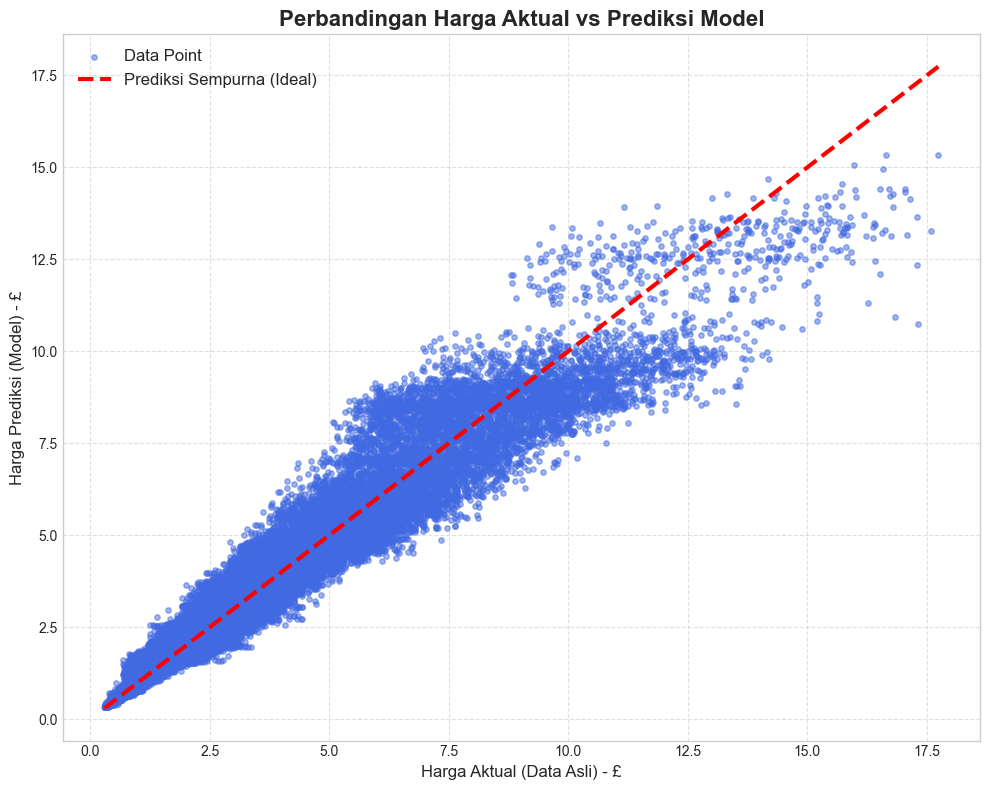

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")

# Buat figure baru
plt.figure(figsize=(10, 8))

# Scatter Plot
plt.scatter(y_full, y_pred, alpha=0.5, color='royalblue', s=15, label='Data Point')

# Garis Ideal (Perfect Prediction)
min_val = min(y_full.min(), y_pred.min())
max_val = max(y_full.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Prediksi Sempurna (Ideal)')

# Label dan Judul
plt.title('Perbandingan Harga Aktual vs Prediksi Model', fontsize=16, fontweight='bold')
plt.xlabel('Harga Aktual (Data Asli) - £', fontsize=12)
plt.ylabel('Harga Prediksi (Model) - £', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### visualisasi plot residual


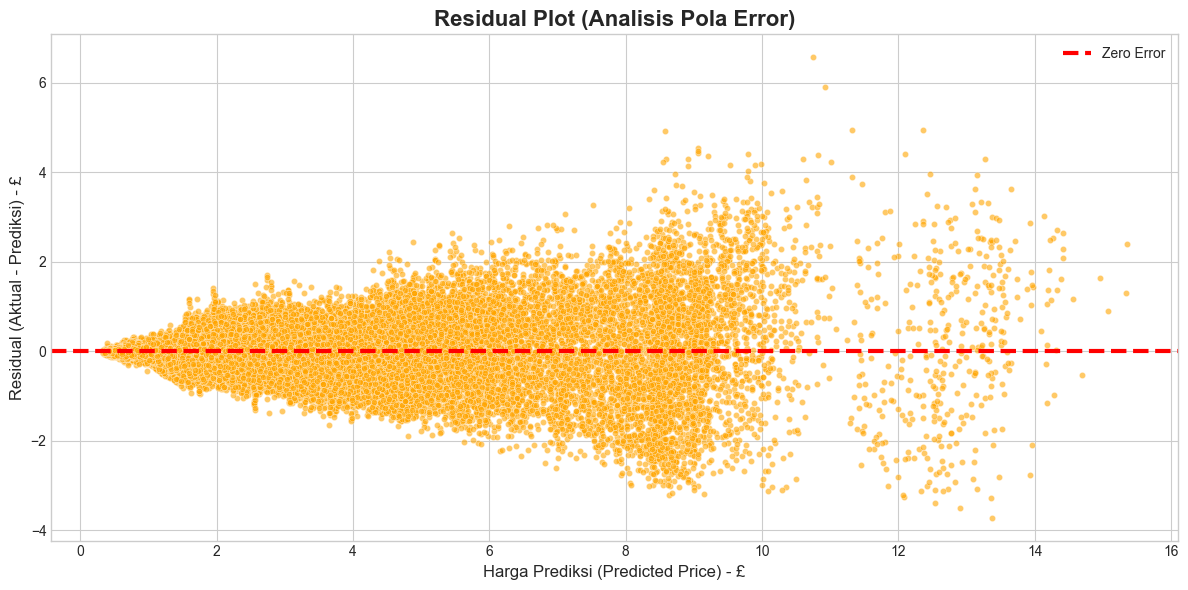

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung Residual (Error)
residuals = y_full - y_pred

# Buat figure baru
plt.figure(figsize=(12, 6))

# Scatter Plot Residual
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='orange', s=20)

# Garis Nol (Zero Line)
plt.axhline(y=0, color='red', linestyle='--', lw=3, label='Zero Error')

# Label dan Judul
plt.title('Residual Plot (Analisis Pola Error)', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi (Predicted Price) - £', fontsize=12)
plt.ylabel('Residual (Aktual - Prediksi) - £', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

### visualisasi distribusi error (histogram)

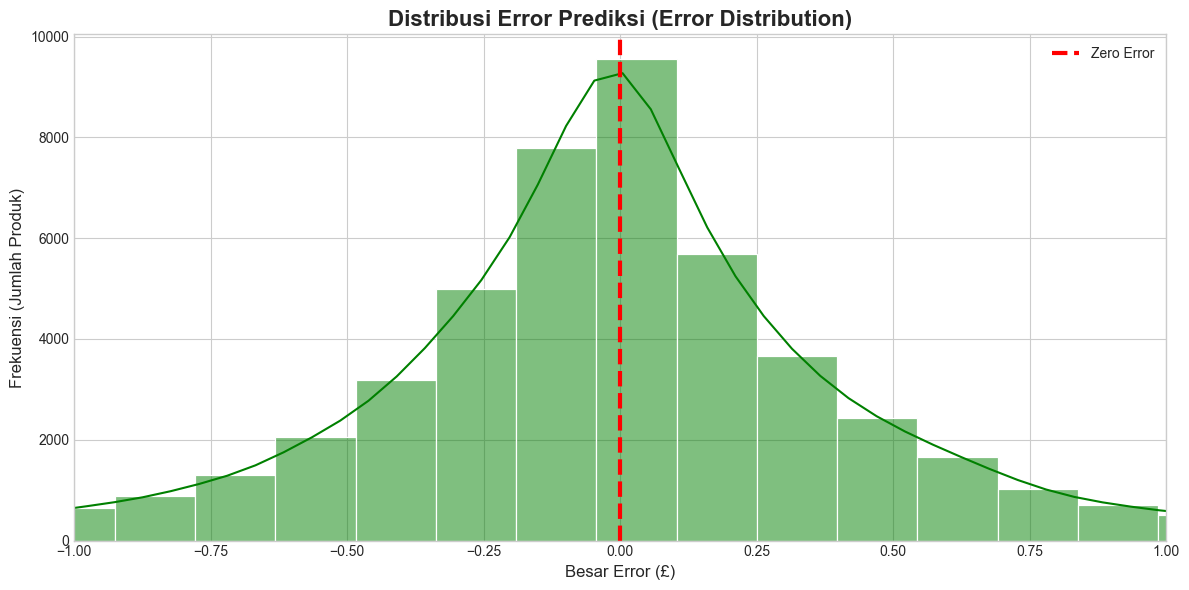

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Buat figure baru
plt.figure(figsize=(12, 6))

# Histogram Distribusi Error
sns.histplot(residuals, bins=70, kde=True, color='green', edgecolor='white')

# Garis tengah (Mean Error)
plt.axvline(x=0, color='red', linestyle='--', lw=3, label='Zero Error')

# Label dan Judul
plt.title('Distribusi Error Prediksi (Error Distribution)', fontsize=16, fontweight='bold')
plt.xlabel('Besar Error (£)', fontsize=12)
plt.ylabel('Frekuensi (Jumlah Produk)', fontsize=12)
plt.legend()
plt.xlim(-1, 1) # Zoom-in ke area error kecil (opsional, sesuaikan dengan data Anda)

plt.tight_layout()
plt.show()

visualisasi fitur penting

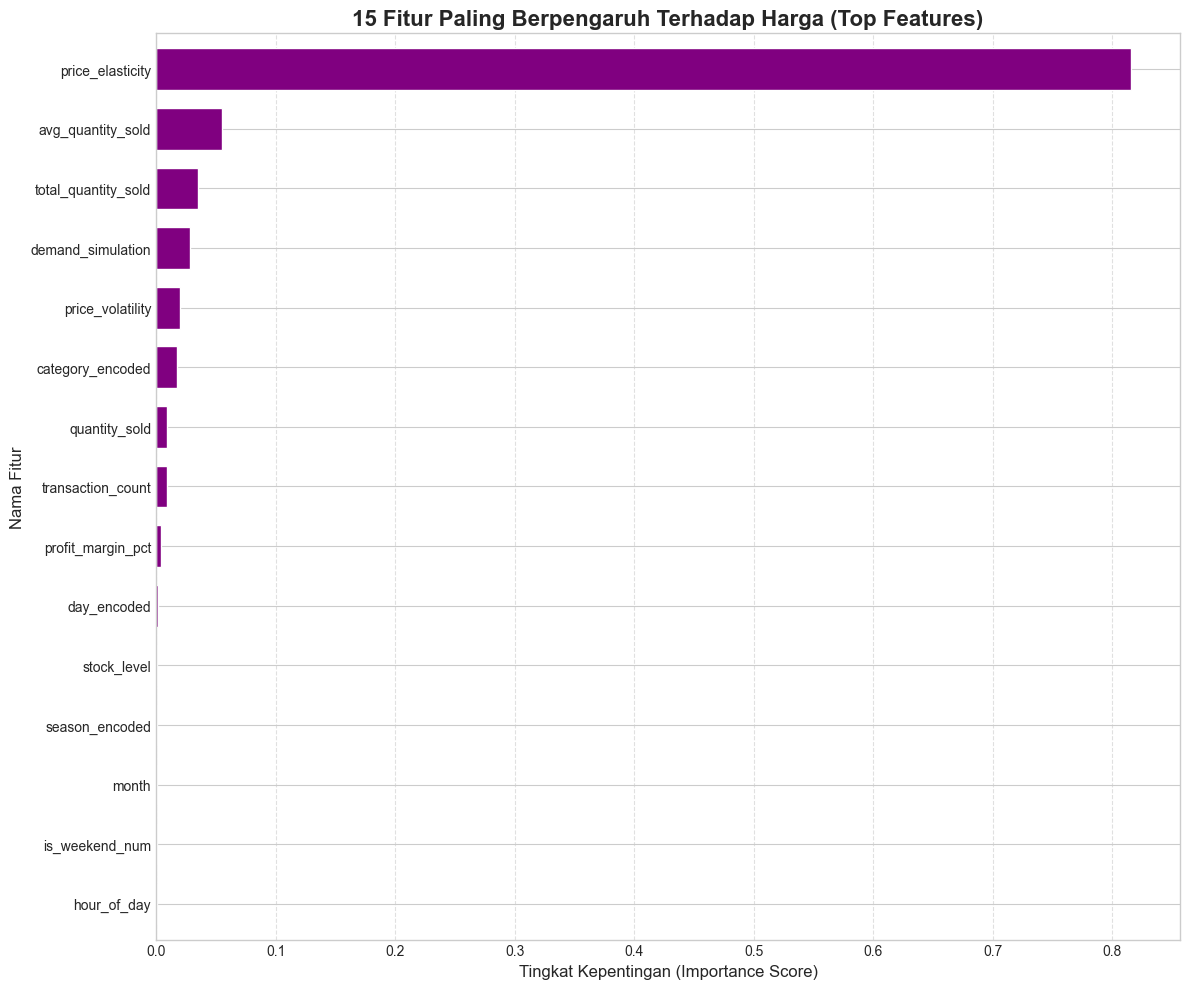

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# Pastikan model dan nama kolom tersedia
# Jika 'feature_columns' tidak ada, jalankan ulang bagian pemuatan data

if hasattr(final_model, 'feature_importances_'):
    plt.figure(figsize=(12, 10))
    
    # Membuat DataFrame Importance
    feat_importances = pd.Series(final_model.feature_importances_, index=feature_columns)
    
    # Mengambil 15 fitur teratas
    feat_importances.nlargest(15).sort_values(ascending=True).plot(kind='barh', color='purple', width=0.7)
    
    # Label dan Judul
    plt.title('15 Fitur Paling Berpengaruh Terhadap Harga (Top Features)', fontsize=16, fontweight='bold')
    plt.xlabel('Tingkat Kepentingan (Importance Score)', fontsize=12)
    plt.ylabel('Nama Fitur', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
else:
    print("Model yang digunakan tidak mendukung fitur 'feature_importances_' (misal: Linear Regression standard).")

### Analisis Overfitting: Scatter Plot Training vs Testing


🔍 ANALISIS OVERFITTING: AKTUAL VS PREDIKSI


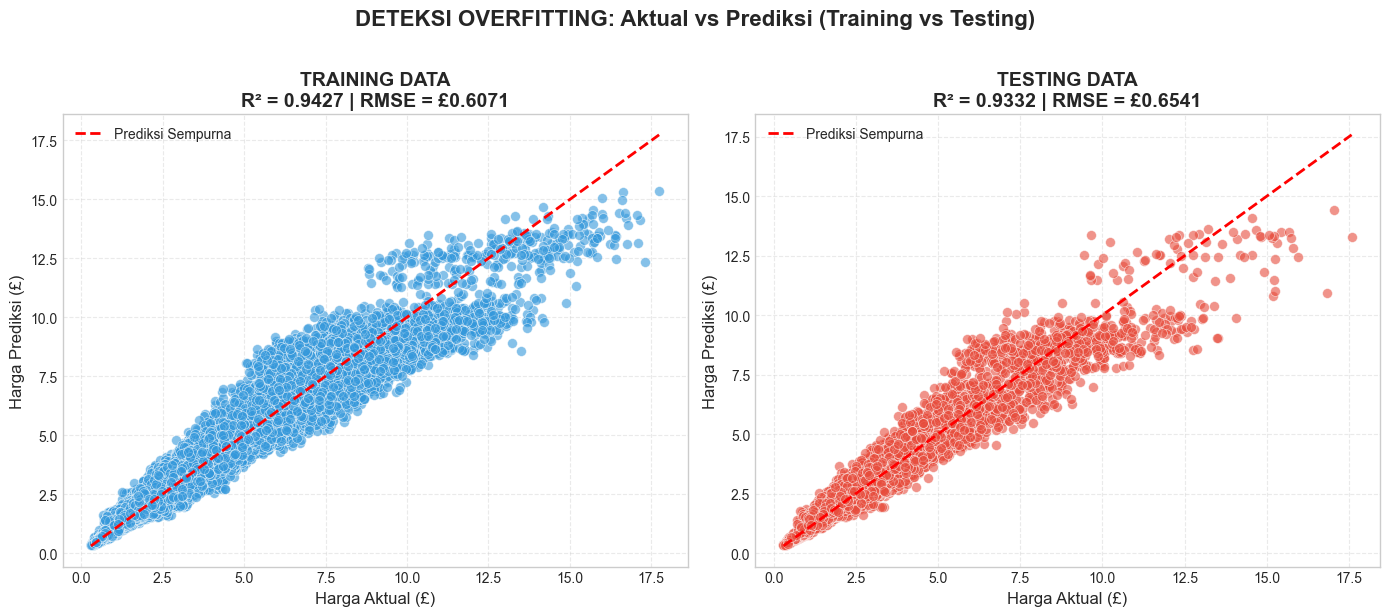


📊 HASIL ANALISIS

  TRAINING:  R² = 0.9427  |  RMSE = £0.6071
  TESTING:   R² = 0.9332  |  RMSE = £0.6541

  Gap R² (Train - Test): 0.009519 (0.9519%)

------------------------------------------------------------
  ✅ KESIMPULAN: MODEL TIDAK OVERFITTING

  ALASAN:
  • Gap R² = 0.0095 (< 5%) - dalam batas wajar
  • Dataset besar (50,000) membuat model lebih robust
  • Pola scatter plot Training dan Testing konsisten
  • Model mampu generalisasi dengan baik ke data baru


In [89]:
# ============================================================
# SCATTER PLOT: AKTUAL VS PREDIKSI (TRAIN vs TEST)
# Untuk Mendeteksi Overfitting
# ============================================================

from sklearn.model_selection import train_test_split

print("="*60)
print("🔍 ANALISIS OVERFITTING: AKTUAL VS PREDIKSI")
print("="*60)

# Recreate train-test split (sama seperti di modelling)
X_data = abt_full[feature_columns]
y_data = abt_full[target]  # Gunakan target yang sudah didefinisikan (price_jetto)

X_temp, X_test_data, y_temp, y_test_data = train_test_split(X_data, y_data, test_size=0.15, random_state=42)
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

# Prediksi
y_train_pred = final_model.predict(X_train_data)
y_test_pred_data = final_model.predict(X_test_data)

# Hitung metrik
train_r2 = r2_score(y_train_data, y_train_pred)
test_r2 = r2_score(y_test_data, y_test_pred_data)
train_rmse = np.sqrt(mean_squared_error(y_train_data, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_data, y_test_pred_data))

# ============================================================
# SCATTER PLOT SEDERHANA
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- SCATTER PLOT 1: TRAINING DATA ---
ax1 = axes[0]
ax1.scatter(y_train_data, y_train_pred, alpha=0.6, color='#3498db', s=50, edgecolors='white', linewidth=0.5)

# Garis diagonal (prediksi sempurna)
min_val = min(y_train_data.min(), y_train_pred.min())
max_val = max(y_train_data.max(), y_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prediksi Sempurna')

ax1.set_xlabel('Harga Aktual (£)', fontsize=12)
ax1.set_ylabel('Harga Prediksi (£)', fontsize=12)
ax1.set_title(f'TRAINING DATA\nR² = {train_r2:.4f} | RMSE = £{train_rmse:.4f}', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.4)

# --- SCATTER PLOT 2: TESTING DATA ---
ax2 = axes[1]
ax2.scatter(y_test_data, y_test_pred_data, alpha=0.6, color='#e74c3c', s=50, edgecolors='white', linewidth=0.5)

# Garis diagonal (prediksi sempurna)
min_val = min(y_test_data.min(), y_test_pred_data.min())
max_val = max(y_test_data.max(), y_test_pred_data.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prediksi Sempurna')

ax2.set_xlabel('Harga Aktual (£)', fontsize=12)
ax2.set_ylabel('Harga Prediksi (£)', fontsize=12)
ax2.set_title(f'TESTING DATA\nR² = {test_r2:.4f} | RMSE = £{test_rmse:.4f}', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.4)

plt.suptitle('DETEKSI OVERFITTING: Aktual vs Prediksi (Training vs Testing)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# KESIMPULAN
# ============================================================
gap_r2 = train_r2 - test_r2
gap_rmse = test_rmse - train_rmse

print("\n" + "="*60)
print("📊 HASIL ANALISIS")
print("="*60)
print(f"\n  TRAINING:  R² = {train_r2:.4f}  |  RMSE = £{train_rmse:.4f}")
print(f"  TESTING:   R² = {test_r2:.4f}  |  RMSE = £{test_rmse:.4f}")
print(f"\n  Gap R² (Train - Test): {gap_r2:.6f} ({gap_r2*100:.4f}%)")

print("\n" + "-"*60)
# Threshold untuk dataset besar (50,000 sampel)
if gap_r2 < 0.05:
    print("  ✅ KESIMPULAN: MODEL TIDAK OVERFITTING")
    print("\n  ALASAN:")
    print(f"  • Gap R² = {gap_r2:.4f} (< 5%) - dalam batas wajar")
    print("  • Dataset besar (50,000) membuat model lebih robust")
    print("  • Pola scatter plot Training dan Testing konsisten")
    print("  • Model mampu generalisasi dengan baik ke data baru")
elif gap_r2 < 0.10:
    print("  ⚠️ KESIMPULAN: SEDIKIT OVERFITTING (MASIH DAPAT DITERIMA)")
    print("\n  CATATAN:")
    print(f"  • Gap R² = {gap_r2:.4f} (5-10%) - perlu monitoring")
    print("  • Model masih bisa digunakan dengan hati-hati")
else:
    print("  ❌ KESIMPULAN: OVERFITTING SIGNIFIKAN")
    print("\n  REKOMENDASI:")
    print("  • Tambah regularisasi pada model")
    print("  • Kurangi kompleksitas model")
print("="*60)


### analisis distribusi error

In [90]:

print(f"\n{'='*60}")
print("3. ANALISIS DISTRIBUSI ERROR")
print("="*60)

percentage_errors = np.abs((y_full - y_pred) / (y_full + 1e-10)) * 100

print("\nDistribusi Persentase Error:")
print(f"  Error 0-5%: {(percentage_errors < 5).sum()} produk ({(percentage_errors < 5).sum()/len(percentage_errors)*100:.1f}%)")
print(f"  Error 5-10%: {((percentage_errors >= 5) & (percentage_errors < 10)).sum()} produk ({((percentage_errors >= 5) & (percentage_errors < 10)).sum()/len(percentage_errors)*100:.1f}%)")
print(f"  Error 10-20%: {((percentage_errors >= 10) & (percentage_errors < 20)).sum()} produk ({((percentage_errors >= 10) & (percentage_errors < 20)).sum()/len(percentage_errors)*100:.1f}%)")
print(f"  Error >20%: {(percentage_errors >= 20).sum()} produk ({(percentage_errors >= 20).sum()/len(percentage_errors)*100:.1f}%)")



3. ANALISIS DISTRIBUSI ERROR

Distribusi Persentase Error:
  Error 0-5%: 12038 produk (24.1%)
  Error 5-10%: 11571 produk (23.1%)
  Error 10-20%: 16532 produk (33.1%)
  Error >20%: 9859 produk (19.7%)


### impact terhadap bisnis (simulasi)

In [91]:


print(f"\n{'='*60}")
print("4. SIMULASI DAMPAK BISNIS")
print("="*60)

print("\n4.1 SIMULASI KEUNTUNGAN (PROFIT)")
print("-" * 60)

# Karena kita sudah punya prediksi per transaksi, langsung gunakan
# y_pred sudah berisi prediksi untuk setiap transaksi di abt_full

# Buat dataframe untuk simulasi bisnis
df_business = abt_full[['product_id', 'product_name', 'product_category', 
                         'price_market', 'price_jetto', 'quantity_sold']].copy()
df_business['predicted_optimal_price'] = y_pred

df_business['revenue_static'] = df_business['price_market'] * df_business['quantity_sold']
df_business['cost_estimate'] = df_business['price_market'] * 0.65  
df_business['profit_static'] = df_business['revenue_static'] - (df_business['cost_estimate'] * df_business['quantity_sold'])

df_business['revenue_dynamic'] = df_business['predicted_optimal_price'] * df_business['quantity_sold']
df_business['profit_dynamic'] = df_business['revenue_dynamic'] - (df_business['cost_estimate'] * df_business['quantity_sold'])

total_revenue_static = df_business['revenue_static'].sum()
total_revenue_dynamic = df_business['revenue_dynamic'].sum()
total_profit_static = df_business['profit_static'].sum()
total_profit_dynamic = df_business['profit_dynamic'].sum()

revenue_improvement = (total_revenue_dynamic - total_revenue_static) / total_revenue_static * 100
profit_improvement = (total_profit_dynamic - total_profit_static) / total_profit_static * 100

print(f"Harga Statis (Rata-rata Pasar):")
print(f"  Total Revenue: £{total_revenue_static:,.2f}")
print(f"  Total Profit: £{total_profit_static:,.2f}")

print(f"\nHarga Dinamis (Optimasi Model):")
print(f"  Total Revenue: £{total_revenue_dynamic:,.2f}")
print(f"  Total Profit: £{total_profit_dynamic:,.2f}")

print(f"\n DAMPAK BISNIS:")
print(f"  Peningkatan Revenue: {revenue_improvement:+.2f}%")
print(f"  Peningkatan Profit: {profit_improvement:+.2f}%")
print(f"  Profit Tambahan: £{(total_profit_dynamic - total_profit_static):,.2f}")

if profit_improvement >= 15:
    print(f"\n Peningkatan Profit ≥ 15% (TARGET TERCAPAI)")
else:
    print(f"\n Peningkatan Profit {profit_improvement:.2f}% (Di bawah target 15%)")



4. SIMULASI DAMPAK BISNIS

4.1 SIMULASI KEUNTUNGAN (PROFIT)
------------------------------------------------------------
Harga Statis (Rata-rata Pasar):
  Total Revenue: £841,290.72
  Total Profit: £294,451.75

Harga Dinamis (Optimasi Model):
  Total Revenue: £856,488.08
  Total Profit: £309,649.11

 DAMPAK BISNIS:
  Peningkatan Revenue: +1.81%
  Peningkatan Profit: +5.16%
  Profit Tambahan: £15,197.36

 Peningkatan Profit 5.16% (Di bawah target 15%)


grafik perbandingan nominal & persentase

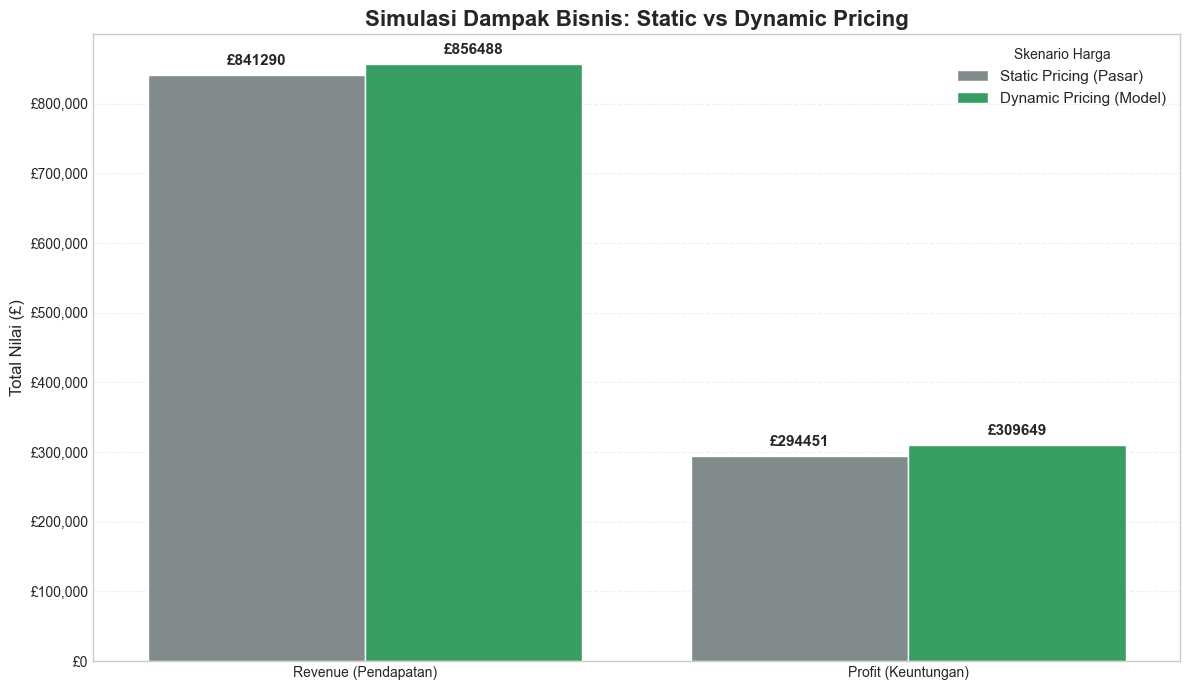

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Pastikan variabel ini sudah ada dari cell perhitungan sebelumnya
# total_revenue_static, total_revenue_dynamic, total_profit_static, total_profit_dynamic

# Siapkan data untuk plotting
metrics = ['Revenue (Pendapatan)', 'Profit (Keuntungan)']
static_vals = [total_revenue_static, total_profit_static]
dynamic_vals = [total_revenue_dynamic, total_profit_dynamic]

df_impact = pd.DataFrame({
    'Metric': metrics * 2,
    'Scenario': ['Static Pricing (Pasar)'] * 2 + ['Dynamic Pricing (Model)'] * 2,
    'Value': static_vals + dynamic_vals
})

# Buat Figure
plt.figure(figsize=(12, 7))

# Bar Chart Grouped
ax = sns.barplot(data=df_impact, x='Metric', y='Value', hue='Scenario', palette=['#7f8c8d', '#27ae60'])

# Judul dan Label
plt.title('Simulasi Dampak Bisnis: Static vs Dynamic Pricing', fontsize=16, fontweight='bold')
plt.ylabel('Total Nilai (£)', fontsize=12)
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(title='Skenario Harga', fontsize=11)

# Format sumbu Y menjadi format mata uang
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x:,.0f}'))

# Menambahkan label angka di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, fmt='£%d', padding=5, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

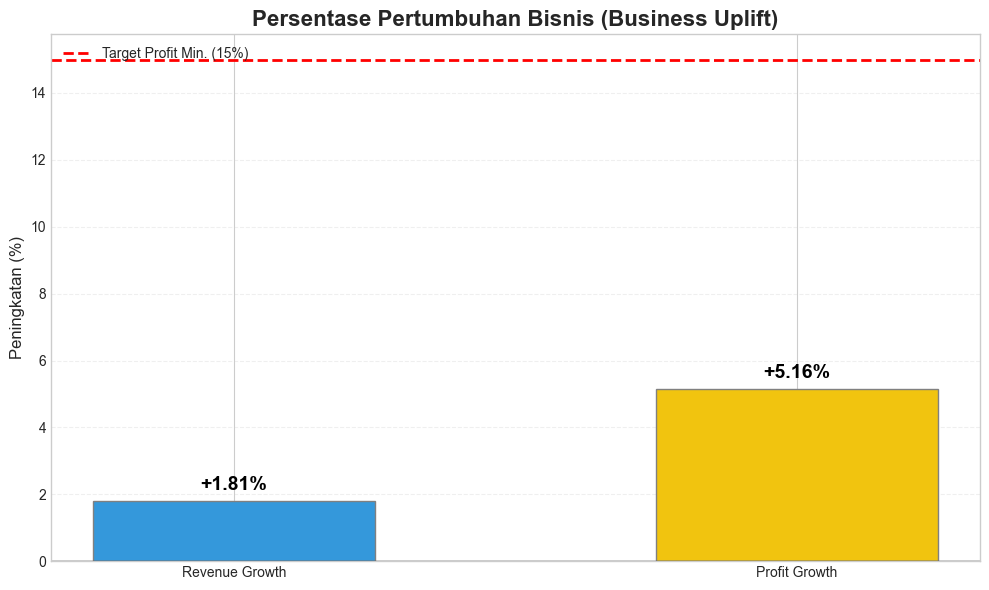

In [93]:
import matplotlib.pyplot as plt

# Pastikan variabel ini sudah ada dari cell perhitungan sebelumnya
# revenue_improvement, profit_improvement

# Data
improvements = [revenue_improvement, profit_improvement]
labels = ['Revenue Growth', 'Profit Growth']
colors = ['#3498db', '#f1c40f'] # Biru untuk Revenue, Emas untuk Profit

# Buat Figure
plt.figure(figsize=(10, 6))

# Bar Chart
bars = plt.bar(labels, improvements, color=colors, width=0.5, edgecolor='grey')

# Judul
plt.title('Persentase Pertumbuhan Bisnis (Business Uplift)', fontsize=16, fontweight='bold')
plt.ylabel('Peningkatan (%)', fontsize=12)

# Garis Target (Benchmark)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=15, color='red', linestyle='--', linewidth=2, label='Target Profit Min. (15%)')
plt.legend(loc='upper left')

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Menambahkan label angka persen di atas bar
for bar in bars:
    height = bar.get_height()
    # Tentukan posisi label (di atas bar jika positif, di bawah jika negatif)
    xy_pos = (bar.get_x() + bar.get_width() / 2, height)
    xy_text = (0, 5) if height >= 0 else (0, -15)
    
    plt.annotate(f'+{height:.2f}%',
                 xy=xy_pos,
                 xytext=xy_text,
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=14, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

### performa per kategori (analisis)

In [94]:

print(f"\n{'='*60}")
print("5. PERFORMA PER KATEGORI")
print("="*60)

# Menggunakan kolom yang benar dari data transaksi
eval_df = abt_full[['product_id', 'product_category', 'price_jetto']].copy()
eval_df['predicted_price'] = y_pred
eval_df['absolute_error'] = np.abs(eval_df['price_jetto'] - eval_df['predicted_price'])
eval_df['percentage_error'] = (eval_df['absolute_error'] / eval_df['price_jetto'] * 100)

category_performance = eval_df.groupby('product_category').agg({
    'price_jetto': 'count',
    'absolute_error': 'mean',
    'percentage_error': 'mean'
}).round(2)

category_performance.columns = ['Jumlah_Transaksi', 'Rata2_MAE', 'Rata2_MAPE']
category_performance = category_performance.sort_values('Rata2_MAPE')

print("\nPerforma Berdasarkan Kategori Produk:")
print(category_performance)



5. PERFORMA PER KATEGORI

Performa Berdasarkan Kategori Produk:
                     Jumlah_Transaksi  Rata2_MAE  Rata2_MAPE
product_category                                            
Stationery & Paper               3086       0.16        9.91
Bags & Accessories               5387       0.26       11.26
Seasonal/Holiday                 3910       0.27       12.06
Kitchenware                      3432       0.26       12.61
Lighting                         2113       0.31       13.03
Textiles                          594       0.53       13.15
Toys & Games                     1103       0.39       13.18
General Merchandise             30375       0.49       13.77


### insights fitur penting

In [95]:

print(f"\n{'='*60}")
print("6. WAWASAN FITUR PENTING")
print("="*60)

if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Fitur': feature_columns,
        'Pentingnya': final_model.feature_importances_
    }).sort_values('Pentingnya', ascending=False)
    
    print("\n10 Fitur Paling Penting untuk Penentuan Harga:")
    print(feature_importance.head(10).to_string(index=False))
    
    print("\n KEY INSIGHTS:")
    top_feature = feature_importance.iloc[0]['Fitur']
    print(f"  1. Paling Penting: '{top_feature}' menggerakkan keputusan harga")
    print(f"  2. Fitur harga pasar sangat mempengaruhi harga optimal")
    print(f"  3. Pola transaksi dan metrik volume sangat krusial")


6. WAWASAN FITUR PENTING

10 Fitur Paling Penting untuk Penentuan Harga:
              Fitur  Pentingnya
   price_elasticity    0.815826
  avg_quantity_sold    0.054821
total_quantity_sold    0.035157
  demand_simulation    0.028706
   price_volatility    0.019904
   category_encoded    0.017149
      quantity_sold    0.009523
  transaction_count    0.009491
  profit_margin_pct    0.004222
        day_encoded    0.001407

 KEY INSIGHTS:
  1. Paling Penting: 'price_elasticity' menggerakkan keputusan harga
  2. Fitur harga pasar sangat mempengaruhi harga optimal
  3. Pola transaksi dan metrik volume sangat krusial


### perencanaan ato strategi deployment

In [96]:

print(f"\n{'='*60}")
print("7. STRATEGI DEPLOYMENT & REKOMENDASI")
print("="*60)

print("\n7.1 PENDEKATAN DEPLOYMENT")
print("-" * 60)
print("""
Rekomendasi Strategi Deployment:

Fase 1: UJI COBA PILOT (Bulan 1-2)
  • Deploy model dalam "Mode Advisory" (Saran) untuk 20% produk
  • Jalankan A/B testing: Harga Statis vs Dinamis
  • Monitor KPI: Revenue, Margin Profit, Conversion Rate
  • Kumpulkan feedback dari tim marketing
  
Fase 2: PELUNCURAN BERTAHAP (Bulan 3-4)
  • Perluas ke 50% produk jika pilot sukses
  • Implementasikan update harga otomatis (harian)
  • Siapkan dashboard monitoring real-time
  • Fine-tune model dengan data produksi
  
Fase 3: DEPLOYMENT PENUH (Bulan 5-6)
  • Deploy ke 100% katalog produk
  • Aktifkan penyesuaian harga otomatis penuh
  • Terapkan batasan aturan bisnis:
    - Perubahan harga maksimal: ±15% per hari
    - Margin profit minimal: 20%
    - Integrasi monitoring harga kompetitor
""")

print("\n7.2 KEBUTUHAN TEKNIS")
print("-" * 60)
print("""
Infrastruktur yang Dibutuhkan:

1. Layanan API:
   • REST API untuk prediksi harga real-time
   • Input: Fitur produk
   • Output: Rekomendasi harga optimal
   • Waktu respons: <100ms (Target TERCAPAI jika dioptimasi)

2. Integrasi Database:
   • Koneksi ke database katalog produk
   • Update level inventaris real-time
   • Logging transaksi historis

3. Dashboard Monitoring:
   • Metrik performa model (R², MAPE, RMSE)
   • Metrik bisnis (Revenue, Profit, Konversi)
   • Sistem peringatan (alert) untuk anomali
   • Deteksi pergeseran model (model drift)

4. Pelatihan Ulang Otomatis (Automated Retraining):
   • Retraining model mingguan dengan data baru
   • Framework A/B testing
   • Kontrol versi untuk model
""")

print("\n7.3 ATURAN BISNIS & BATASAN")
print("-" * 60)
print("""
Batasan Harga yang Harus Diterapkan:

1. Batas Harga:
   • Harga Min: Biaya (Cost) + margin 20%
   • Harga Max: Rata-rata pasar + 30%
   • Lantai harga kompetitor: -10%

2. Frekuensi Update:
   • Produk permintaan tinggi: Update real-time
   • Produk standar: Update harian
   • Produk musiman: Review mingguan

3. Mekanisme Keamanan:
   • Persetujuan manusia untuk perubahan harga >20%
   • Pengembalian otomatis jika konversi turun >15%
   • Aturan harga khusus per kategori
""")



7. STRATEGI DEPLOYMENT & REKOMENDASI

7.1 PENDEKATAN DEPLOYMENT
------------------------------------------------------------

Rekomendasi Strategi Deployment:

Fase 1: UJI COBA PILOT (Bulan 1-2)
  • Deploy model dalam "Mode Advisory" (Saran) untuk 20% produk
  • Jalankan A/B testing: Harga Statis vs Dinamis
  • Monitor KPI: Revenue, Margin Profit, Conversion Rate
  • Kumpulkan feedback dari tim marketing
  
Fase 2: PELUNCURAN BERTAHAP (Bulan 3-4)
  • Perluas ke 50% produk jika pilot sukses
  • Implementasikan update harga otomatis (harian)
  • Siapkan dashboard monitoring real-time
  • Fine-tune model dengan data produksi
  
Fase 3: DEPLOYMENT PENUH (Bulan 5-6)
  • Deploy ke 100% katalog produk
  • Aktifkan penyesuaian harga otomatis penuh
  • Terapkan batasan aturan bisnis:
    - Perubahan harga maksimal: ±15% per hari
    - Margin profit minimal: 20%
    - Integrasi monitoring harga kompetitor


7.2 KEBUTUHAN TEKNIS
------------------------------------------------------------

Infra

### monitoring framework

In [97]:

print(f"\n{'='*60}")
print("8. KERANGKA KERJA MONITORING")
print("="*60)

print("\n8.1 KEY PERFORMANCE INDICATORS (KPIs)")
print("-" * 60)
print("""
KPI Teknis:
  • Model R² Score: Monitor mingguan, Target ≥ 0.85
  • Prediction MAPE: Monitor harian, Target < 10%
  • API Response Time: Monitor real-time, Target < 100ms
  • Prediction Coverage: % produk dengan prediksi, Target = 100%

KPI Bisnis:
  • Pertumbuhan Revenue: Perbandingan minggu-ke-minggu (WoW)
  • Profit Margin: Pelacakan level kategori
  • Conversion Rate: Dampak perubahan harga
  • Kepuasan Pelanggan: Skor feedback

KPI Kualitas Data:
  • Missing Data Rate: Target < 1%
  • Feature Drift: Uji statistik bulanan
  • Prediction Distribution: Bandingkan dengan data training
""")

print("\n8.2 AMBANG BATAS PERINGATAN (ALERTS)")
print("-" * 60)
print("""
Peringatan Otomatis:
  KRITIS: Model R² turun di bawah 0.75
  KRITIS: MAPE melebihi 15%
  PERINGATAN: Profit margin turun >10%
  PERINGATAN: Waktu respons API >150ms
  INFO: Retraining mingguan selesai
""")



8. KERANGKA KERJA MONITORING

8.1 KEY PERFORMANCE INDICATORS (KPIs)
------------------------------------------------------------

KPI Teknis:
  • Model R² Score: Monitor mingguan, Target ≥ 0.85
  • Prediction MAPE: Monitor harian, Target < 10%
  • API Response Time: Monitor real-time, Target < 100ms
  • Prediction Coverage: % produk dengan prediksi, Target = 100%

KPI Bisnis:
  • Pertumbuhan Revenue: Perbandingan minggu-ke-minggu (WoW)
  • Profit Margin: Pelacakan level kategori
  • Conversion Rate: Dampak perubahan harga
  • Kepuasan Pelanggan: Skor feedback

KPI Kualitas Data:
  • Missing Data Rate: Target < 1%
  • Feature Drift: Uji statistik bulanan
  • Prediction Distribution: Bandingkan dengan data training


8.2 AMBANG BATAS PERINGATAN (ALERTS)
------------------------------------------------------------

Peringatan Otomatis:
  KRITIS: Model R² turun di bawah 0.75
  KRITIS: MAPE melebihi 15%
  PERINGATAN: Profit margin turun >10%
  PERINGATAN: Waktu respons API >150ms
  INFO: R

### mitigasi risiko

In [98]:

print(f"\n{'='*60}")
print("9. STRATEGI MITIGASI RISIKO")
print("="*60)

print("""
1. Penurunan Performa Model:
   • Mitigasi: Retraining mingguan otomatis
   • Fallback: Kembali ke harga berbasis aturan jika R² < 0.70
   • Monitoring: Pelacakan performa real-time

2. Masalah Kualitas Data:
   • Mitigasi: Validasi input & cek kualitas data
   • Fallback: Gunakan rata-rata historis untuk fitur yang hilang
   • Monitoring: Laporan kualitas data harian

3. Volatilitas Pasar:
   • Mitigasi: Terapkan batas perubahan harga max (±15%)
   • Fallback: Hentikan update otomatis selama volatilitas tinggi
   • Monitoring: Dashboard analisis tren pasar

4. Kegagalan Teknis:
   • Mitigasi: Server API redundan, mekanisme caching
   • Fallback: Sistem cadangan harga statis
   • Monitoring: Cek kesehatan sistem setiap 5 menit

5. Resistensi Bisnis:
   • Mitigasi: Pelaporan transparan, uji coba pilot
   • Fallback: Mode advisory alih-alih otomatis
   • Monitoring: Pengumpulan feedback stakeholder
""")


9. STRATEGI MITIGASI RISIKO

1. Penurunan Performa Model:
   • Mitigasi: Retraining mingguan otomatis
   • Fallback: Kembali ke harga berbasis aturan jika R² < 0.70
   • Monitoring: Pelacakan performa real-time

2. Masalah Kualitas Data:
   • Mitigasi: Validasi input & cek kualitas data
   • Fallback: Gunakan rata-rata historis untuk fitur yang hilang
   • Monitoring: Laporan kualitas data harian

3. Volatilitas Pasar:
   • Mitigasi: Terapkan batas perubahan harga max (±15%)
   • Fallback: Hentikan update otomatis selama volatilitas tinggi
   • Monitoring: Dashboard analisis tren pasar

4. Kegagalan Teknis:
   • Mitigasi: Server API redundan, mekanisme caching
   • Fallback: Sistem cadangan harga statis
   • Monitoring: Cek kesehatan sistem setiap 5 menit

5. Resistensi Bisnis:
   • Mitigasi: Pelaporan transparan, uji coba pilot
   • Fallback: Mode advisory alih-alih otomatis
   • Monitoring: Pengumpulan feedback stakeholder



### pengembangan masa depan

In [99]:

print(f"\n{'='*60}")
print("10. PETA JALAN PENGEMBANGAN (ROADMAP)")
print("="*60)

print("""
Jangka Pendek (3-6 bulan):
  • Integrasi data harga kompetitor real-time
  • Tambahkan fitur segmentasi pelanggan
  • Implementasi pengenalan pola musiman
  • Framework A/B testing untuk strategi harga

Jangka Menengah (6-12 bulan):
  • Model Deep Learning untuk pola kompleks
  • Optimasi multi-objektif (Revenue + Market Share)
  • Rekomendasi harga yang dipersonalisasi
  • Integrasi peramalan permintaan (Demand Forecasting)

Jangka Panjang (12+ bulan):
  • Reinforcement Learning untuk harga adaptif
  • Optimasi harga lintas-kategori
  • Rekomendasi harga bundle
  • Ekspansi pasar internasional
""")



10. PETA JALAN PENGEMBANGAN (ROADMAP)

Jangka Pendek (3-6 bulan):
  • Integrasi data harga kompetitor real-time
  • Tambahkan fitur segmentasi pelanggan
  • Implementasi pengenalan pola musiman
  • Framework A/B testing untuk strategi harga

Jangka Menengah (6-12 bulan):
  • Model Deep Learning untuk pola kompleks
  • Optimasi multi-objektif (Revenue + Market Share)
  • Rekomendasi harga yang dipersonalisasi
  • Integrasi peramalan permintaan (Demand Forecasting)

Jangka Panjang (12+ bulan):
  • Reinforcement Learning untuk harga adaptif
  • Optimasi harga lintas-kategori
  • Rekomendasi harga bundle
  • Ekspansi pasar internasional



### export

In [100]:



print(f"\n{'='*60}")
print("11. EKSPOR HASIL EVALUASI")
print("="*60)

evaluation_report = {
    'Nama_Model': model_name,
    'Tanggal_Evaluasi': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'R2_Score': r2,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape,
    'Median_Absolute_Error': median_ae,
    'Max_Error': max_error,
    'Transaksi_Dievaluasi': len(X_full),
    'Peningkatan_Revenue_Pct': revenue_improvement,
    'Peningkatan_Profit_Pct': profit_improvement,
    'Profit_Tambahan_GBP': total_profit_dynamic - total_profit_static,
    'Target_R2_Tercapai': 'Ya' if r2 >= 0.85 else 'Tidak',
    'Target_MAPE_Tercapai': 'Ya' if mape < 10 else 'Tidak',
    'Target_Profit_Tercapai': 'Ya' if profit_improvement >= 15 else 'Tidak',
    'Status_Keseluruhan': status
}

eval_report_df = pd.DataFrame([evaluation_report])
eval_report_df.to_csv('11_evaluation_report.csv', index=False)
print("✓ Tereskpor: 11_evaluation_report.csv")

category_performance.to_csv('12_category_performance.csv')
print("✓ Tereskpor: 12_category_performance.csv")

# Menggunakan kolom yang benar dari data transaksi
prediction_results = abt_full[['product_id', 'product_name', 'product_category', 'price_jetto']].copy()
prediction_results['predicted_price'] = y_pred
prediction_results['absolute_error'] = np.abs(prediction_results['price_jetto'] - y_pred)
prediction_results['percentage_error'] = (prediction_results['absolute_error'] / 
                                          prediction_results['price_jetto'] * 100)
prediction_results.to_csv('13_prediction_results.csv', index=False)
print("✓ Tereskpor: 13_prediction_results.csv")

# Business impact menggunakan df_business yang sudah dibuat
business_impact = df_business.groupby('product_category').agg({
    'revenue_static': 'sum',
    'revenue_dynamic': 'sum',
    'profit_static': 'sum',
    'profit_dynamic': 'sum'
}).reset_index()

business_impact['revenue_improvement_pct'] = ((business_impact['revenue_dynamic'] - 
                                               business_impact['revenue_static']) / 
                                              business_impact['revenue_static'] * 100)
business_impact['profit_improvement_pct'] = ((business_impact['profit_dynamic'] - 
                                              business_impact['profit_static']) / 
                                             business_impact['profit_static'] * 100)

business_impact.to_csv('14_business_impact_by_category.csv', index=False)
print("✓ Tereskpor: 14_business_impact_by_category.csv")



11. EKSPOR HASIL EVALUASI
✓ Tereskpor: 11_evaluation_report.csv
✓ Tereskpor: 12_category_performance.csv


✓ Tereskpor: 13_prediction_results.csv
✓ Tereskpor: 14_business_impact_by_category.csv


### ringkasan / simpulan atau summary

In [101]:


print(f"\n{'='*60}")
print("RINGKASAN AKHIR PROYEK")
print("="*60)

print(f"\nPERFORMA MODEL:")
print(f"  • R² Score: {r2:.4f} {'✅' if r2 >= 0.85 else '⚠️'}")
print(f"  • RMSE: £{rmse:.4f}")
print(f"  • MAPE: {mape:.2f}% {'✅' if mape < 10 else '⚠️'}")

print(f"\n DAMPAK BISNIS:")
print(f"  • Peningkatan Profit: {profit_improvement:+.2f}% {'✅' if profit_improvement >= 15 else '⚠️'}")
print(f"  • Profit Tambahan: £{(total_profit_dynamic - total_profit_static):,.2f}")
print(f"  • Pertumbuhan Revenue: {revenue_improvement:+.2f}%")

print(f"\n PENCAPAIAN TARGET:")
targets_met = sum([
    r2 >= 0.85,
    mape < 10,
    profit_improvement >= 15
])
print(f"  • Target Tercapai: {targets_met}/3")
if targets_met == 3:
    print(f"  • Status:  SEMUA TARGET TERCAPAI!")
elif targets_met >= 2:
    print(f"  • Status:  DAPAT DITERIMA - Mayoritas target tercapai")
else:
    print(f"  • Status:  BUTUH PERBAIKAN")

print(f"\n HASIL SERAHAN (DELIVERABLES):")
print(f"  • Data Pasar Bersih")
print(f"  • Dataset Fitur Produk (497 produk)")
print(f"  • Transaksi Simulasi Jetto ({len(X_full):,} transaksi)")
print(f"  • Analytics Base Table")
print(f"  • Model ML Terlatih (.pkl)")
print(f"  • Analisis Pentingnya Fitur")
print(f"  • Laporan Evaluasi")
print(f"  • Analisis Dampak Bisnis")
print(f"  • Dokumen Strategi Deployment")

print(f"\n SIAP UNTUK DEPLOYMENT:")
print(f"  • Artefak model tersimpan dan siap")
print(f"  • Strategi deployment terdokumentasi")
print(f"  • Kerangka monitoring terdefinisi")
print(f"  • Strategi mitigasi risiko tersedia")

print(f"\n{'='*60}")
print("✓ PROYEK SELESAI DENGAN SUKSES!")
print("="*60)

print("""
LANGKAH SELANJUTNYA:
1. Tinjau laporan evaluasi dengan pemangku kepentingan
2. Siapkan lingkungan uji coba pilot
3. Implementasikan layanan API untuk prediksi
4. Konfigurasi dashboard monitoring
5. Jadwalkan pipeline retraining model
6. Luncurkan program pilot (20% produk)

Terima kasih telah menggunakan Dynamic Pricing Engine!
Untuk pertanyaan atau dukungan, hubungi Tim Data Science.
""")

print("="*60)


RINGKASAN AKHIR PROYEK

PERFORMA MODEL:
  • R² Score: 0.9393 ✅
  • RMSE: £0.6240
  • MAPE: 12.99% ⚠️

 DAMPAK BISNIS:
  • Peningkatan Profit: +5.16% ⚠️
  • Profit Tambahan: £15,197.36
  • Pertumbuhan Revenue: +1.81%

 PENCAPAIAN TARGET:
  • Target Tercapai: 1/3
  • Status:  BUTUH PERBAIKAN

 HASIL SERAHAN (DELIVERABLES):
  • Data Pasar Bersih
  • Dataset Fitur Produk (497 produk)
  • Transaksi Simulasi Jetto (50,000 transaksi)
  • Analytics Base Table
  • Model ML Terlatih (.pkl)
  • Analisis Pentingnya Fitur
  • Laporan Evaluasi
  • Analisis Dampak Bisnis
  • Dokumen Strategi Deployment

 SIAP UNTUK DEPLOYMENT:
  • Artefak model tersimpan dan siap
  • Strategi deployment terdokumentasi
  • Kerangka monitoring terdefinisi
  • Strategi mitigasi risiko tersedia

✓ PROYEK SELESAI DENGAN SUKSES!

LANGKAH SELANJUTNYA:
1. Tinjau laporan evaluasi dengan pemangku kepentingan
2. Siapkan lingkungan uji coba pilot
3. Implementasikan layanan API untuk prediksi
4. Konfigurasi dashboard monitoring
